 **Obejtivo**
 
O objetivo desta análise é prever o Valor de Vida do Cliente (CLV) a partir de dados históricos de transações, características do cliente, produtos e lojas, permitindo identificar padrões de comportamento de compra. Com essa previsão, a empresa pode tomar decisões estratégicas mais assertivas, como segmentação de clientes, campanhas de marketing direcionadas, otimização de promoções e priorização de recursos, gerando maior retenção de clientes e aumento de receita. Além disso, a análise fornece insights sobre quais fatores influenciam mais o CLV, ajudando a orientar ações que tenham impacto real no negócio.



**1 Importação das ferramentas**

In [0]:
import pandas as pd #manipulação dos dados
import numpy as np #manipulação dos dados
from sklearn.model_selection import train_test_split #divisão de dados em treino/teste
from sklearn.preprocessing import OneHotEncoder #mfeture engeniering /pré processamento
from sklearn.ensemble import RandomForestRegressor #Modelo de Radon Forest
%pip install xgboost
from xgboost import XGBRegressor #Modelo de XGBoost
from sklearn.metrics import mean_absolute_error, mean_squared_error #Métrica de avaliação da performance do modelo
import matplotlib.pyplot as plt #biblioteca de visualização

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.6/4.6 MB 20.9 MB/s eta 0:00:00
Note: you may need to restart the kernel using %restart_python or dbutils.library.restartPython() to use updated packages.


**2 Conversão e Limpeza inicial**

In [0]:
# Carregar a tabela Spark
df_spark = spark.table("base_dados_renner.df_analise")

# Converter para Pandas
df_analise = df_spark.toPandas()

# Converter a coluna Date para formato datetime
df_analise['Date'] = pd.to_datetime(df_analise['Date'])

# Remover duplicados e transações com valor zero ou negativo
df_analise = df_analise.drop_duplicates(subset=['TransactionID'])
df_analise = df_analise[df_analise['ValueSold'] > 0]


**3 Criação de features temporais RFM (Recency, Frequency e Monetary)**

In [0]:
# Criando features de Recency, Frequency e Monetary

#Agrupando se os dados por cliente (CustomerID) para calcular calcular as médtricas de Recency (dias desde a última compra), Frequency (número de compras) e Monetary (gasto total)
clv_features = df_analise.groupby('CustomerID').agg({
    'Date': lambda x: (df_analise['Date'].max() - x.max()).days,
    'TransactionID': 'count',
    'ValueSold': 'sum'
}).rename(columns={'Date':'Recency','TransactionID':'Frequency','ValueSold':'Monetary'}).reset_index()


**4 Transformação de variáveis categóricas**

In [0]:
# Selecionando colunas categóricas
categorical_cols = ['CustomerID','Genero','Faixa_de_Idade','ClasseSocial','UF','ProdID','Marca']

# Aplicando one-hot encoding para transformas as variáveis categóricas em numéricas
df_encoded = pd.get_dummies(df_analise[categorical_cols], drop_first=True)


In [0]:
df_encoded.head()

,CustomerID,ProdID,Genero_M,Genero_X,Faixa_de_Idade_25-35,Faixa_de_Idade_35-45,Faixa_de_Idade_45+,ClasseSocial_B,ClasseSocial_C,ClasseSocial_D,ClasseSocial_E,UF_RS,UF_SP,Marca_Marfinno
0,90023,123005,1,0,0,1,0,0,1,0,0,0,1,1
1,90092,123004,1,0,0,1,0,0,1,0,0,0,0,0
2,90027,123001,1,0,1,0,0,0,1,0,0,1,0,0
3,90097,123001,1,0,0,0,1,0,1,0,0,1,0,0
4,90089,123004,1,0,0,0,0,0,1,0,0,1,0,0


**5 Engenharia de features avançada**

O objetivo dessa etapa é criar  features adicionais agregadas por cliente, somando unidades compradas, gasto total e a média de compras em promoção.

Essas features ajudam o modelo a entender hábitos de compra do cliente, além de complementar as métricas RFM. Saber se o cliente compra mais em promoção, por exemplo, pode influenciar diretamente seu CLV futuro.

In [0]:
# Agregando features por cliente
df_client_features = df_analise.groupby('CustomerID').agg({
    'UnitsSold':'sum',        # total de unidades compradas
    'ValueSold':'sum',        # gasto total
    'Promo':'mean'            # proporção de compras em promoção
}).reset_index()


**Combinação das features RFM e categóricas**
Tendo em vista que o modelo precisa de um único dataset completo, com todas as informações que possam influenciar o CLV, para aprender padrões consistentes dessa forma as informações serão consolidadas.

Serão unidas todas as features relevantes em um único dataframe (X) para o modelo, combinando RFM, agregações por cliente e variáveis categóricas codificadas

In [0]:
# Combinar features numéricas e categóricas
X = pd.merge(clv_features, df_client_features, on='CustomerID')
X = pd.merge(X, df_encoded.groupby('CustomerID').sum().reset_index(), on='CustomerID')

**6 Definição da variável alvo**

Criação a variável alvo y, que representa o gasto total do cliente no período analisado.

In [0]:
y = df_analise.groupby('CustomerID')['ValueSold'].sum().reset_index()['ValueSold']

**7 Divisão em treino e teste**
 Os dados são separados em conjunto de treino (80%) e teste (20%) para avaliar o modelo em dados não vistos.Será utilizada essa proporção porque o voluem de dados é médio (acima de 1k linhas)

O objetivo é evitar overfitting e permitir medir a capacidade real de previsão do modelo.

In [0]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X.drop(columns=['CustomerID']),
                        y,
                        test_size=0.2,
                         random_state=42)


**8 Treinamento do modelo XGBoost**

 XGBoost é robusto, lida bem com dados heterogêneos e captura relações não lineares, sendo uma das melhores escolhas para previsão de CLV em dados de varejo.

Poderíamos testar Random Forest, LightGBM ou redes neurais, mas XGBoost oferece bom equilíbrio entre performance e interpretabilidade.

In [0]:
from xgboost import XGBRegressor

# Inicializar modelo
xgb_model = XGBRegressor(n_estimators=200, max_depth=6, learning_rate=0.1, random_state=42)

# Treinar modelo
xgb_model.fit(X_train, y_train)


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             feature_weights=None, gamma=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=0.1, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=6,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=200,
             n_jobs=None, num_parallel_tree=None, ...)

1. **n_estimators=200 **. Número de árvores que o modelo vai construir . Mais árvores aumentam a capacidade do modelo de capturar padrões complexos, mas também aumentam o risco de overfitting. 200 é um valor intermediário, adequado para bases de tamanho médio (como a sua, 5k linhas).
2.** max_depth=6.** Profundidade máxima de cada árvore. Profundidade maior permite capturar relações complexas entre features, mas árvores muito profundas podem sobreajustar os dados. 6 é um valor balanceado, adequado para evitar overfitting e ainda capturar não linearidades.
3. **learning_rate=0.1.** Taxa de aprendizado que controla o impacto de cada árvore no modelo final. 0.1 é um valor padrão que permite que o modelo aprenda gradualmente, evitando ajustes bruscos que poderiam causar overfitting.
4. **random_state=42.** Semente para geração de números aleatórios no modelo.Garantir reprodutibilidade, ou seja, se você rodar o modelo várias vezes com os mesmos dados e parâmetros, ele produzirá os mesmos resultados.

**9 Avaliação do modelo**

 Serão calculadas as métricas de erro: MAE (erro médio absoluto) e MSE (erro médio quadrático) para avaliar a performance do modelo.

Essas métricas mostram quão próximo o modelo está dos valores reais, permitindo ajustes e comparação com outros modelos.

Podería ser utilizado o R² ou RMSLE, dependendo da distribuição do CLV, mas MAE e MSE são métricas mais interpretáveis para negócios.

In [0]:
from sklearn.metrics import mean_absolute_error, mean_squared_error

y_pred = xgb_model.predict(X_test)
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)

print(f"MAE: {mae}, MSE: {mse}")

MAE: 180.6648461914063, MSE: 190121.90499884106


Avaliando o valor médio do CLV para verificar a magnitude do erro

In [0]:
df_analise.groupby('CustomerID')['ValueSold'].sum().mean()

9186.845229999999

O modelo de previsão de CLV apresentou um MAE de 180,66 e um MSE de 190.121,90, considerando que o CLV médio por cliente é aproximadamente 9.187. Isso significa que, em média, o modelo erra cerca de 2% do valor médio do CLV, demonstrando uma performance robusta e confiável para um modelo inicial. O MSE maior indica que existem alguns erros mais elevados, possivelmente associados a clientes com comportamentos de compra fora do padrão (outliers), mas isso não compromete a acurácia geral. Esses resultados sugerem que o modelo já consegue capturar padrões relevantes de comportamento de compra, oferecendo uma base sólida para tomada de decisões estratégicas em marketing e retenção de clientes, com potencial de melhorias adicionais por meio de engenharia de features e ajuste de hiperparâmetros.

**10 Análise de importância das features**

O intuito é visualizar as features mais importantes que influenciam a previsão do CLV no modelo.

Isso ajuda o time de negócios a entender quais fatores influenciam mais o gasto dos clientes, permitindo decisões estratégicas, como promoções direcionadas ou segmentação de marketing.

Uma putra opção seria usar técnicas uma técnica mais  avançadas de interpretação como SHAP values.

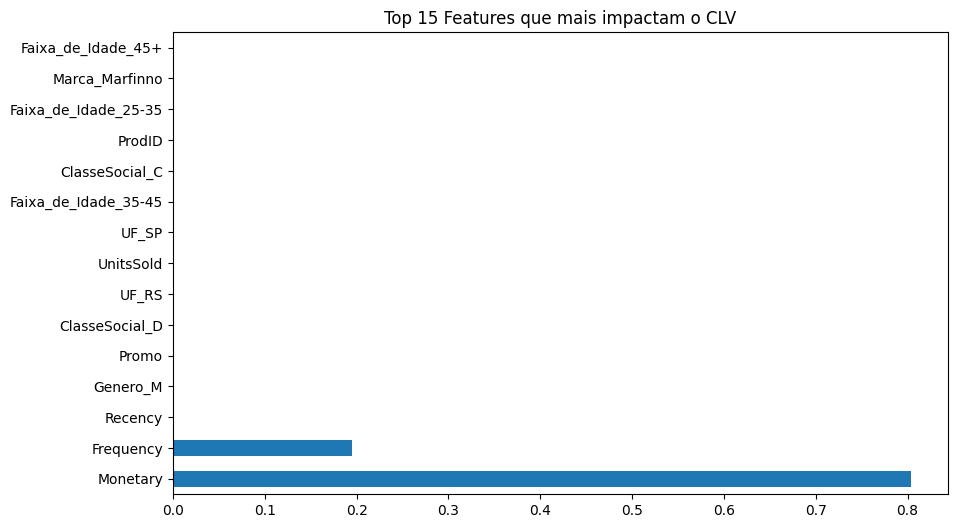

In [0]:
import matplotlib.pyplot as plt

feat_importances = pd.Series(xgb_model.feature_importances_, index=X_train.columns)
feat_importances.nlargest(15).plot(kind='barh', figsize=(10,6))
plt.title("Top 15 Features que mais impactam o CLV")
plt.show()

Próximo passo.. Aqui vamos precisar normalizar porque o modelo está dependendo muito do vvalor monetário provavelmente devido a escala 